# CS5489 - Machine Learning
# Lecture 7a - Unsupervised Learning - Clustering
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Unsupervised Learning
2. Parametric clustering
    1. K-means
    2. Gaussian mixture models (GMMs)
    3. Dirichlet Process GMMs
3. Non-parametric clustering and Mean-shift
4. Spectral clustering

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import skimage.util

# Unsupervised Learning
- Unsupervised learning only considers the input data $\mathbf{x}$.
  - There are no output values.
- **Goal:** Try to discover inherent properties in the data.
  - Clustering
  - Dimensionality Reduction
  - Manifold Embedding

# Clustering
- Find clusters of similar items in the data.
  - Find a representative item that can represent all items in the cluster.
- **For example:** grouping iris flowers by their measurements.
  - Features are sepal width and petal length.
<img width="500px" src="imgs/cluster.png">

# Clustering
- Data is set of vectors $\{\mathbf{x}_1,\cdots,\mathbf{x}_n\}$
  - Each data point is a vector $\mathbf{x}\in\mathbb{R}^d$.
- **Goal:** group similar data together.
  - groups are also called clusters.
  - each data point is assigned with a cluster index ($y\in\{1,\cdots,K\}$)
    - $K$ is the number of clusters.

In [2]:
axbox = [0, 8, 1.5, 5]

# make a colormap for viewing classes
mycmap = matplotlib.colors.ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
cols = ['r', 'g', 'b']
jet = plt.get_cmap('jet')
rbow = plt.get_cmap('rainbow')

al = 0.4
rbow_data2 = {
    'red': lambda x:   (1-al) + al*abs(2 * x - 0.5),
    'green': lambda x: (1-al) + al*sin(x * pi),
    'blue': lambda x:  (1-al) + al*cos(x * pi / 2),
} 
rbow2 = matplotlib.colors.LinearSegmentedColormap('rainbow2', rbow_data2)

# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris3.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (setosa=0, versicolor=1, virginica=2)

km = cluster.KMeans(n_clusters=3, random_state=4487)
Yp = km.fit_predict(X)

clusterfig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], edgecolors='k')
plt.axis(axbox); plt.axis('equal'); plt.grid(True)
plt.title('data')

plt.subplot(1,2,2)
for j in range(3):
    inds = (Yp == j)
    plt.scatter(X[inds,0], X[inds,1], c=cols[j], label='Cluster '+str(j+1), edgecolors='k')
plt.axis(axbox); plt.axis('equal'); plt.grid(True)
plt.title('clustered data')
leg = plt.legend(fontsize=9)
plt.close()

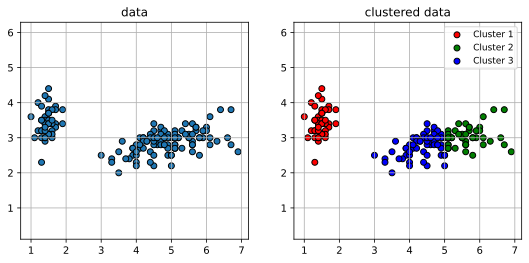

In [3]:
clusterfig

# K-Means Clustering
- **Idea:**
  - there are $K$ clusters.
  - each cluster is represented by a _cluster center_.
    - $\mathbf{c}_j \in \mathbb{R}^d$, $j\in\{1,\cdots,K\}$
  - assign each data point to the closest cluster center.
    - assignment variable $z_i\in\{1,\cdots,K\}$ indexes the cluster center of $\mathbf{x}_i$.

In [4]:
cc = km.cluster_centers_
kmfig = plt.figure()
plt.scatter(X[:,0], X[:,1], c=Yp, cmap=rbow, edgecolors='k')
plt.scatter(cc[:,0], cc[:,1], c=arange(3), s=250, cmap=rbow2, marker='*', label='Cluster centers', edgecolors='k')
plt.axis(axbox); plt.axis('equal'); plt.grid(True)
plt.legend(fontsize=9)
plt.close()

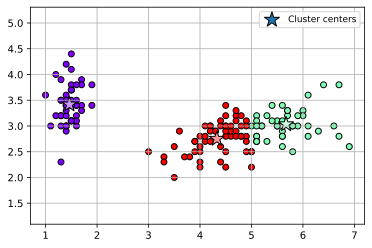

In [5]:
kmfig

# K-means Clustering Objective
- **Objective:** minimize the total sum-squared difference between points and their centers
$$ \min_{\mathbf{c}_1,\cdots,\mathbf{c}_K, z_1,\cdots,z_n} \sum_{i=1}^n || \mathbf{x}_i - \mathbf{c}_{z_i}||^2$$


# K-means Clustering Objective
- _How to pick the cluster centers?_
  - Assume the assignments $z_i$ are known.
  - Pick the cluster centers that minimize the squared distance to all its cluster members.
$$ \min_{\mathbf{c}_1,\cdots,\mathbf{c}_K} \sum_{i=1}^n || \mathbf{x}_i - \mathbf{c}_{z_i}||^2$$


- Solution: 
  - if the assignments $\{z_i\}$ are known...
    - let $C_j$ be the set of points assigned to cluster $j$
      - $C_j = \{ \mathbf{x}_i | z_i=j\}$
    - For each cluster, we have
      - $ \mathbf{c}_j = \mathrm{argmin} \sum_{i \in C_j} || \mathbf{x}_i - \mathbf{c}_{j}||^2$
    - Take the derivative and set to 0:
      $$ \begin{aligned}&\frac{d}{d\mathbf{c}_j} \sum_{i \in C_j} || \mathbf{x}_i - \mathbf{c}_{j}||^2 = \sum_{i \in C_j} 2 (\mathbf{x}_i - \mathbf{c}_{j})(-1) = 0 \\
       & \Rightarrow \sum_{i \in C_j}\mathbf{x}_i - |C_j| \mathbf{c}_{j} = 0\end{aligned}$$
    - Cluster center is the mean of the points in the cluster
      - $\mathbf{c}_j = \frac{1}{|C_j|}\sum_{\mathbf{x}_i \in C_j} \mathbf{x}_i$

# K-means Clustering Objective
- _How to pick the assignments?_
  - Assume the clusters $\{\mathbf{c}_1, \cdots, \mathbf{c}_K\}$ are *known*.
  - Pick the assignments that minimize the squared distance to the clusters.
$$ \min_{z_1, \cdots,z_n} \sum_{i=1}^n || \mathbf{x}_i - \mathbf{c}_{z_i}||^2$$
  - For each data point, 
    - $z_i = \mathop{\mathrm{argmin}}_{j\in\{1,\cdots K\}} || \mathbf{x}_i - \mathbf{c}_{j}||^2$
    - i.e., assign point $\mathbf{x}_i$ to its closest cluster.

# Chicken and Egg Problem
- Cluster assignment of each point depends on the cluster centers.
- Location of cluster center depends on which points are assigned to it.

- **Solution**: just iterate between the two steps.
  - Note: in each step we are holding one set of variables fixed, while minimizing over the others.
  - Thus we are always minimizing the original objective!

# K-means Algorithm
- Pick initial cluster centers
- Repeat:
  - 1) calculate assignment $z_i$ for each point $\mathbf{x}_i$: closest cluster center using Euclidean distance.
  - 2) calculate cluster center $\mathbf{c}_j$ as average of points assigned to cluster $j$.
- This procedure will converge eventually.

In [6]:
# ax is the axis
# cmap is colormap to use
# cl is the index of components to show [default is None which means all components]
def make_ellipses(means, covars, ax, cmap, cl=None):
    dim = means.shape[1]
    if cl is None:
        cl = range(means.shape[0])
    for n in cl:
        mycv = covars[n]
        if mycv.size==1:
            mycv = mycv*eye(dim)
        elif mycv.size==dim:
            mycv = diag(mycv)
            
        v, w = linalg.eigh(mycv)

        u = w[0] / linalg.norm(w[0])
        angle = arctan2(u[1], u[0])
        angle = 180 * angle / pi  # convert to degrees
        s   = sqrt(v)  # stddev
        
        for f in [1,2,3]:
            ss = s*f  
            ell = matplotlib.patches.Ellipse(means[n, :2], 2*ss[0], 2*ss[1],
                                      180 + angle, color=cmap(float(n)/max(max(cl),1)))
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.15)
            ax.add_artist(ell)

def plot_clusters(model, axbox, X, Y, pcmap, ccmap, showregions=False):
    # model = kmeans, gmm, dpgmm
    # X = points
    # pcmap = colormap for points
    # ccmap = colormap for centers
    
    name = model.__class__.__name__
    
    if (name == 'KMeans'):
        cc = model.cluster_centers_
        cl = range(model.n_clusters)
        cv = None
    elif (name == 'GMM') or (name == 'GaussianMixture'):
        cc = model.means_
        cl = range(model.n_components)
        cv = model.covariances_
    elif (name == 'DPGMM') or (name == 'BayesianGaussianMixture'):
        cl = unique(Y)        # find active clusters
        cc = model.means_[cl] # get means
        cv = model.covariances_[cl]
    elif (name == 'VBGMM'):
        cl = unique(Y)        # find active clusters
        cc = model.means_[cl] # get means
        cv = None
    elif (name == 'MeanShift'):
        cc = model.cluster_centers_
        cl = range(len(cc))
        cv = None
    elif (name == 'SpectralClustering'):
        cc = None
        cl = range(model.n_clusters)
        cv = None
        
    if showregions:    
        dx = axbox[1]-axbox[0]
        dy = axbox[3]-axbox[2]
        
        axbox2 = [ axbox[0]-0.5*dx, axbox[1]+0.5*dx,
                   axbox[2]-0.5*dy, axbox[3]+0.5*dy]
        
        # grid of points
        xr = [linspace(axbox2[0],axbox2[1],300), 
              linspace(axbox2[2],axbox2[3],300)]
        xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
        allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
        
        # predictions
        Ypred = model.predict(allpts).reshape(xgrid0.shape)
        
        plt.imshow(Ypred, origin='lower', extent=axbox2, aspect='auto', 
           vmin=min(cl), vmax=max(cl), alpha=0.2, cmap=pcmap)

    # show ellipses
    if (cv is not None) and (not showregions):  
        make_ellipses(cc, cv, plt.gca(), pcmap, None)
    
    # show points
    if X is not None:
        plt.scatter(X[:,0], X[:,1], c=Y, cmap=pcmap, edgecolors='k')
    
    # show centers
    if cc is not None:
        plt.scatter(cc[:,0], cc[:,1], c=cl, s=250, cmap=ccmap, marker='*', edgecolors='k')

    plt.axis('equal');  plt.axis(axbox);  plt.grid(True)  
        
    # return number of clusters found
    return (len(cl),)

In [7]:
random.seed(123)
indinit = random.permutation(len(X))[0:3]
ccinit = X[indinit,:]


for i in range(6):
    if i==0:
        kmifig1 = plt.figure(figsize=(10,3))
        py = 1
        px = 2
        ioff = 0
        tstr = 'initial'
        km = cluster.KMeans(n_clusters=3, max_iter=1, n_init=1, init=ccinit)
        Yp = km.fit_predict(X)
        km.cluster_centers_ = ccinit  # force clusters to initial points (hack)        
        Yp = km.predict(X)
    else:
        km = cluster.KMeans(n_clusters=3, max_iter=i, n_init=1, init=ccinit)
        Yp = km.fit_predict(X)
        tstr = 'iteration ' + str(i)

    plt.subplot(py,px,i+1+ioff)
    plot_clusters(km, axbox, X, Yp, rbow, rbow2)
    plt.title(tstr)

    if i==1:
        plt.close()
        kmifig2 = plt.figure(figsize=(10,6))
        py = 2
        px = 2
        ioff = -2
plt.close()

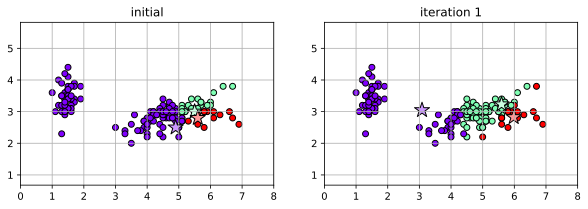

In [8]:
kmifig1

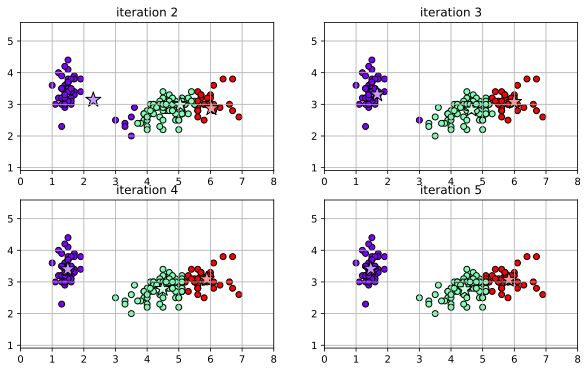

In [9]:
kmifig2

# Important Note
- The final result depends on the initial cluster centers!
  - Some bad initializations will yield poor clustering results!
  - (Technically, there are multiple local minimums in the objective function)

In [10]:
random.seed(126)
indinit = random.permutation(len(X))[0:3]
ccinit = X[indinit,:]

kmbadfig = plt.figure(figsize=(10,3))

for i,its in enumerate([0,100]):
    if i==0:
        tstr = 'initial'
        km = cluster.KMeans(n_clusters=3, max_iter=1, n_init=1, init=ccinit)
        Yp = km.fit_predict(X)
        km.cluster_centers_ = ccinit  # force clusters to initial points (hack)        
        Yp = km.predict(X)
    else:
        km = cluster.KMeans(n_clusters=3, max_iter=its, n_init=1, init=ccinit)
        Yp = km.fit_predict(X)
        tstr = 'iteration ' + str(its)

    plt.subplot(1,2,i+1)
    plot_clusters(km, axbox, X, Yp, rbow, rbow2)
    plt.title(tstr)
plt.close()

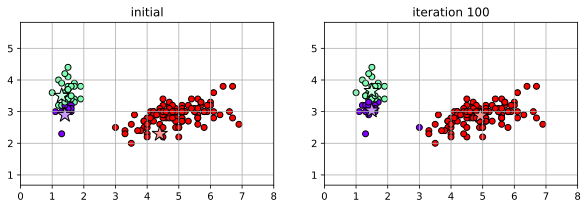

In [11]:
kmbadfig

- **Solution:**
  - Try several times using different initializations.
  - Pick the answer with lowest objective score.
- In scikit-learn,
  - 1) use a smart initialization method called "k-means++", which speeds up convergence.
  - 2) use multiple random initializations.

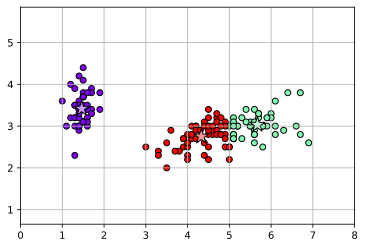

In [12]:
# K-Means with 3 clusters
# (automatically does 10 random initializations)
km = cluster.KMeans(n_clusters=3, random_state=4487)
Yp = km.fit_predict(X)   # cluster data, and return labels

cc = km.cluster_centers_   # the cluster centers
cl = km.labels_            # labels also stored here

plt.figure()
plot_clusters(km, axbox, X, Yp, rbow, rbow2);

# For different K
- We need to choose the appropriate K

In [13]:
ksfig = plt.figure(figsize=(10,6))
for i,K in enumerate([2,3,4,5]):
    km = cluster.KMeans(n_clusters=K, random_state=4487)
    Yp = km.fit_predict(X)

    plt.subplot(2,2,i+1)
    plot_clusters(km, axbox, X, Yp, rbow, rbow2)
    plt.title(str(K) + ' clusters')
plt.close()

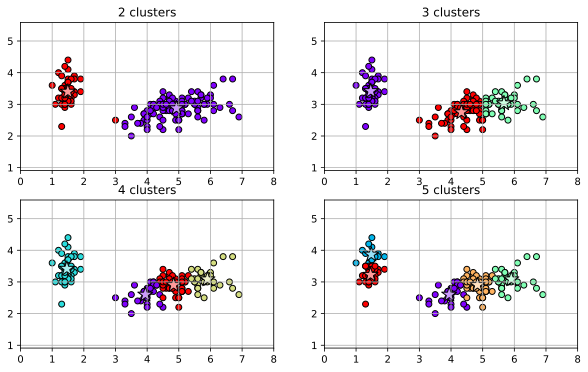

In [14]:
ksfig

- K-means partitions the input space into non-overlapping regions belonging to each cluster
  - assign each location in the space to the closest center.

In [15]:
krfig = plt.figure(figsize=(10,6))
for i,K in enumerate([2,3,4,5]):
    km = cluster.KMeans(n_clusters=K, random_state=4487)
    Yp = km.fit_predict(X)

    plt.subplot(2,2,i+1)
    plot_clusters(km, axbox, X, Yp, rbow, rbow2, showregions=True)
plt.close()

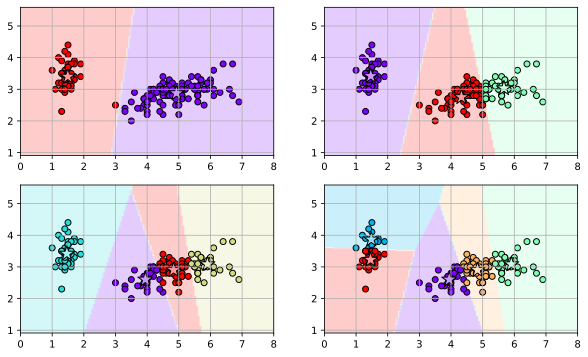

In [16]:
krfig

# Bag-of-X Representation
- K-means can partition the input space into regions.
- Create a new quanitized representation for a set of samples.
  - 1) learn the partition space of the samples using K-means (i.e, the vocabulary)
  - 2) assign each sample to its closest center (i.e., the word)
  - 3) count the number of assignments for each center and form a histogram (i.e., the bag-of-words)
- Called a "bag-of-X" representation.
  - "X" is whatever modality you are using.

# Example: Bag-of-visual-words
- Procedure:
  - 1) extract small patches from images
  - 2) learn the visual words using K-means
  - 3) assign patches to visual words, and formm a histogram for each image.
- Use the bag-of-words model as the new feature vector.

In [17]:
# load images
oli = datasets.fetch_olivetti_faces(data_home="./")
img = oli.images
print(img.shape)

# extract 8x8 window patches with step size of 4x4
patches = skimage.util.view_as_windows(img, (1,8,8), step=(1,4,4))
print(patches.shape)

# reshape patches into 64-dim vectors
patchesall = patches.reshape((prod(patches.shape[0:3]),8*8))
print(patchesall.shape)

# run k-means (mini-batch version can handle large datasets)
# fit k-means, and predict the cluster index for each sample
K = 100
bows = cluster.MiniBatchKMeans(n_clusters=K, random_state=5489, n_init=10)
wordsall = bows.fit_predict(patchesall)  

(400, 64, 64)
(400, 15, 15, 1, 8, 8)
(90000, 64)


In [18]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

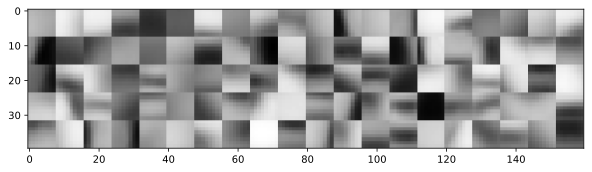

In [19]:
# get the visual words, and show them
visualwords = bows.cluster_centers_.reshape((K,8,8))
plt.figure(figsize=(10,4))
plt.imshow(image_montage(visualwords, maxw=20), cmap='gray', interpolation='nearest');

In [20]:
# reshape the predicted words into small images
print(wordsall.shape)
patches_words = wordsall.reshape(patches.shape[0:3])
print(patches_words.shape)

# build the BoW histogram for each image
bowhist = [bincount(wds.ravel(), minlength=K) for wds in patches_words]

(90000,)
(400, 15, 15)


In [21]:
# visualize the BoW histogram and quantized image.
def show_bow_recon(visualwords, img, words, bowhist):
    plt.subplot(1,4,1)
    plt.imshow(img, cmap='gray')
    plt.title('image')
        
    plt.subplot(1,4,2)
    tmp = []
    for i in words:
        for j in i:
            tmp.append(visualwords[j])
    plt.imshow(image_montage(tmp, maxw=words.shape[1]), cmap='gray', interpolation='nearest')
    plt.title('visual words')
    
    plt.subplot(1,4,3)
    plt.imshow(words, cmap='jet')
    plt.title('word indices')

    plt.subplot(1,4,4)
    plt.bar(range(len(visualwords)), bowhist)
    plt.title('BoW histogram')
    plt.xlabel('word')

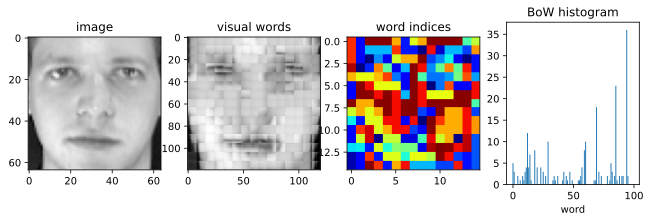

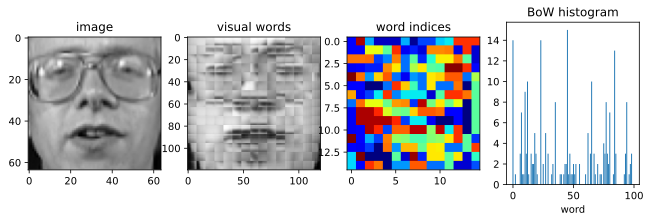

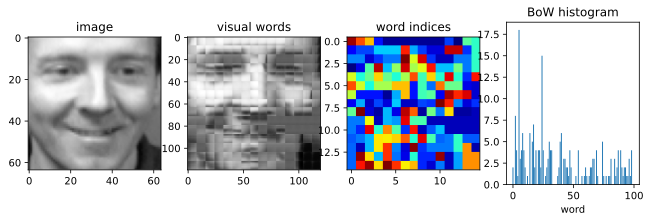

In [22]:
# view some reconstructions, words, and histograms
for t in [0,10,20]:
    plt.figure(figsize=(11,3))
    show_bow_recon(visualwords, img[t], patches_words[t], bowhist[t])
    plt.show()

# Circular clusters
- One problem with K-means is that it assumes that each cluster has a circular shape.
  - based on Euclidean distance to each center
  - Kmeans cannot handle skewed (elliptical) clusters.

In [23]:
random.seed(38)
Xbars,Y = datasets.make_blobs(400,2,centers=[[-15,0],[-5,0],[5,0],[15,0]],cluster_std=0.8)
Xbars[:,0] /=8

X = Xbars
axbox = [-3, 3, -3, 3]

km = cluster.KMeans(n_clusters=4, random_state=4487)
Yp = km.fit_predict(X)

efig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c='b', edgecolors='k')
plt.axis('equal'); plt.grid(True)

plt.subplot(1,2,2)
plot_clusters(km, axbox, X, Yp, rbow, rbow2)
plt.axis('equal'); plt.grid(True)
plt.close()

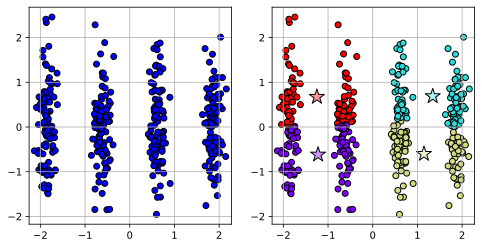

In [24]:
efig

# Gaussian mixture model (GMM)
- A multivariate Gaussian can model a cluster with an elliptical shape.
  - the ellipse shape is controlled by the covariance matrix of the Gaussian
  - the location of the cluster is controlled by the mean.
- Gaussian mixture model is a weighted sum of Gaussians
$$ p(\mathbf{x}) = \sum_{j=1}^K \pi_j N(\mathbf{x}|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)$$
  - Each Gaussian represents one elliptical cluster
    - $\boldsymbol{\mu}_j$ is the mean of the j-th Gaussian. (the location)
    - $\boldsymbol{\Sigma}_j$ is the covariance matrix of the j-th Gaussian. (the ellipse shape)
    - $\pi_j$ is the prior weight of the j-th Gaussian. (how likely is this cluster)

# 1-D example of GMM
- each Gaussian is a "mountain"

In [25]:
eggmm = plt.figure(figsize=(6,3))

x = linspace(-8,8,100)
px = 0.25*(stats.norm.pdf(x+2)/2 ) + 0.75*(stats.norm.pdf(x-3))

plt.plot(x,px, 'b-')
plt.plot(-2,stats.norm.pdf(0)/2*0.25, 'o', label='Cluster 1')
plt.plot(3,stats.norm.pdf(0)*0.75, 's', label='Cluster 2')
plt.legend(loc=0, fontsize=9)
plt.xlabel('x'); plt.ylabel('p(x)')
plt.axis([-8, 8, 0, 0.35])
plt.grid(True)
plt.close()

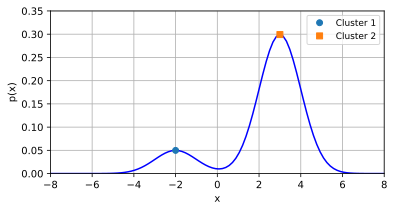

In [26]:
eggmm

# 2D example of GMM
- Each Gaussian defines a "mountain"
  - contours are ellipses

In [27]:
random.seed(38)
mu1 = array([0,0])
mu2 = array([6,8])
st1 = 2*random.normal(0,1,(2,2))
st2 = 2*random.normal(0,1,(2,2))
X1 = dot(random.normal(0,1,[60, 2]), st1.T) + mu1
X2 = dot(random.normal(0,1,[60, 2]), st2.T) + mu2
Xfull = r_[X1,X2]
axboxfull = [-10, 20, -7, 20]
gmmf = mixture.GaussianMixture(n_components=2, covariance_type='full',
                               random_state=4487, n_init=10)
gmmf.fit(Xfull)

efig = plt.figure(figsize=(10,6))
Yp = gmmf.predict(Xfull)

gmm2fig = plt.figure(figsize=(5,4.5))
plot_clusters(gmmf, axboxfull, None, None, rbow, rbow2)
plt.grid(True)
plt.close()

<Figure size 720x432 with 0 Axes>

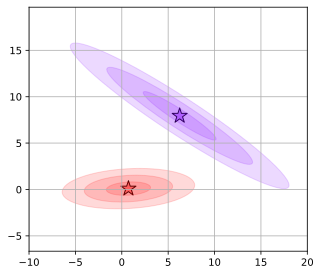

In [28]:
gmm2fig

# Clustering with GMMs
- Using the data, learn a GMM using maximum likelihood estimation:
  $$\max_{\pi,\boldsymbol{\mu},\boldsymbol{\Sigma}} \sum_{i=1}^N \log \sum_{j=1}^K \pi_j N(\mathbf{x}_i|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)$$
  - The learned $\{\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j\}$ are the cluster center and ellipse shape.
  - The learned $\pi_j$ is the cluster population (percentage of points).
- This is a difficult to optimize because the "sum" is inside the "log".

# Expectation Maximization (EM) Algorithm
- An algorithm for finding the MLE solution when there are hidden (unseen) variables $z$.
  - Goal: $\hat{\theta} = \mathop{\mathrm {argmax}}_{\theta} p_{\theta}(\mathbf{x})$
    - where $p_{\theta}(\mathbf{x}) = \sum_z p(\mathbf{x}|z)p(z)$
    - $\theta$ are the parameters.
- Solution: 
  - iterate between estimating the hidden variables $z$ and maximizing w.r.t the parameters $\theta$.


- For GMMS:
  - $z$ is the assignment of $\mathbf{x}$ to one of the Gaussian components.
  - prior probability: $p(z=j) = \pi_j$
  - Gaussian component: $p(\mathbf{x}|z=j)={\cal N}(\mathbf{x}|\mu_j, \Sigma_j)$
  - likelihood: $p(\mathbf{x}) = \sum_z p(\mathbf{x}|z)p(z) = \sum_j \pi_j {\cal N}(\mathbf{x}|\mu_j, \Sigma_j)$

# EM Algorithm
- 1) Select an initial model $\hat{\theta}$
- 2) **E-step**: estimate the hidden variables as their expected value.
  - ${\cal Q}(\theta) = E_{z|\mathbf{x},\hat{\theta}}[\log p_{\theta}(\mathbf{x},z)]$
  - the expectation uses current model parameters $\hat{\theta}$.
- 3) **M-step**: maximize w.r.t $\theta$
  - $\hat{\theta} = \mathop{\mathrm{argmax}}_\theta {\cal Q}(\theta)$
- 4) repeat E- and M-steps until convergence.
  - It's gauranteed to converge.

# Joint likelihood for GMMs
- Joint likelihood of $(\mathbf{x}_i,z_i)$
   $$p(\mathbf{x}_i,z_i) = p(\mathbf{x}_i|z_i) p(z_i) = \pi_{z_i}{\cal N}(\mathbf{x}_i|\mu_{z_i}, \Sigma_{z_i})$$
- annoying because $z_i$ is indexing the parameters.


# Indicator Variable Trick
- Define $z_{ij}$ as the indicator variable that $z_i=j$
  - $z_{ij} = \begin{cases}1, & z_i=j \\ 0, & \mathrm{otherwise}\end{cases}$
- Joint likelihood of $(\mathbf{x}_i,z_i)$       
  - $z_{ij}$ selects the correct Gaussian component.
  $$\begin{aligned} &p(\mathbf{x}_i,z_i) = \prod_{j=1}^K\left(p(\mathbf{x}_i|z_i=j) p(z_i=j)\right)^{z_{ij}} = \prod_{j=1}^K\left(\pi_j{\cal N}(\mathbf{x}_i|\mu_j, \Sigma_j)\right)^{z_{ij}} \\
  &\Rightarrow \log p(\mathbf{x}_i,z_i) = \sum_{j=1}^K z_{ij} \log (\pi_j{\cal N}(\mathbf{x}_i|\mu_j, \Sigma_j))\end{aligned}$$


# EM algorithm for GMMs
- **E-step:** Calculate cluster membership
  - assignment of point $i$ to cluster $j$
    - $\hat{z}_{ij} = p(z_i=j | \mathbf{x}_i) = \frac{{\cal N}(\mathbf{x}_i|\mu_j,\Sigma_j)}{\sum_k {\cal N}(\mathbf{x}_i|\mu_k,\Sigma_k)}$
  - uses "soft" assignment - a data point can have a fractional assignment to different clusters.


- **M-step:** Update each Gaussian cluster (mean, covariance, and weight)
    - uses "soft" weighting
      - "soft" count of points in cluster j: $N_j = \sum_{i=1}^N \hat{z}_{ij}$
      - weight: $\pi_j = N_j / N$
      - mean: $\boldsymbol{\mu}_j = \frac{1}{N_j} \sum_{i=1}^N \hat{z}_{ij} \mathbf{x}_i$
      - variance: $\Sigma_j = \frac{1}{N_j} \sum_{i=1}^N \hat{z}_{ij} (\mathbf{x}_i - \boldsymbol{\mu}_j)^2$
- Similar to K-means, except uses "soft" assignments, rather than "hard" assignments.

In [29]:
# fit a GMM
gmm = mixture.GaussianMixture(n_components=4, random_state=4487, n_init=10)

gmm.fit(X)
Y = gmm.predict(X)

cc = gmm.means_     # the cluster centers

In [30]:
efig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(X[:,0], X[:,1], c='b', edgecolors='k')
plt.grid(True)
plt.title('original data')

ax = plt.subplot(1,3,2)
plot_clusters(gmm, axbox, X, Y, rbow, rbow2)
plt.grid(True)
plt.title('clusters and Gaussians')

axbox = plt.axis()
plt.subplot(1,3,3)
plot_clusters(gmm, axbox, X, Y, rbow, rbow2, showregions=True)
plt.title('clusters and regions')
plt.close()

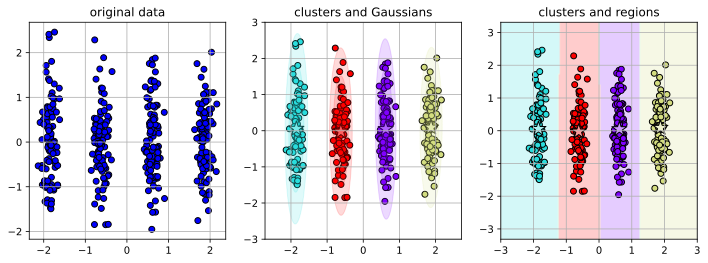

In [31]:
efig

# Covariance matrix
- The covariance matrix is a $d \times d$ matrix.
  $$ \boldsymbol{\Sigma}_j = \begin{bmatrix}a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33} \end{bmatrix}$$
- For high-dimensional data, it can be very large.
  - requires a lot of data to learn effectively.

- Solution:
  - use *diagonal* covariance matrices ($d$ parameters):
  $$ \boldsymbol{\Sigma}_j =\mathrm{diag}(\mathbf{a}) =  \begin{bmatrix}a_{1} & 0 & 0 \\ 0 & a_{2} & 0 \\ 0 & 0 & a_{3} \end{bmatrix}$$
    - Axes of ellipses will be aligned with the axes.
  - use *spherical* covariance matrices (1 parameter)
    $$ \boldsymbol{\Sigma}_j = a \mathbf{I} = \begin{bmatrix}a & 0 & 0 \\ 0 & a & 0 \\ 0 & 0 & a \end{bmatrix}$$
    - Clusters will be circular (similar to K-means)   

In [32]:
random.seed(38)
mu1 = array([0,0])
mu2 = array([6,8])
st1 = 2*random.normal(0,1,(2,2))
st2 = 2*random.normal(0,1,(2,2))
X1 = dot(random.normal(0,1,[60, 2]), st1.T) + mu1
X2 = dot(random.normal(0,1,[60, 2]), st2.T) + mu2
Xfull = r_[X1,X2]

X = Xfull
axbox = [-10, 20, -7, 20]

In [33]:
# full covariance (d*d parameters)
gmmf = mixture.GaussianMixture(n_components=2, 
                               covariance_type='full',
                               random_state=4487, n_init=10)
gmmf.fit(X)

# diagonal convariance (d parameters)
gmmd = mixture.GaussianMixture(n_components=2, 
                               covariance_type='diag',
                               random_state=4487, n_init=10)
gmmd.fit(X)

# spherical covariance (1 parameter)
gmms = mixture.GaussianMixture(n_components=2, 
                               covariance_type='spherical',
                               random_state=4487, n_init=10)
gmms.fit(X)

GaussianMixture(covariance_type='spherical', n_components=2, n_init=10,
                random_state=4487)

In [34]:
efig = plt.figure(figsize=(10,6))

for i,gmm in enumerate([gmmf, gmmd, gmms]):
    Yp = gmm.predict(X)

    ax = plt.subplot(2,3,i+1)
    plot_clusters(gmm, axbox, X, Yp, rbow, rbow2)
    plt.axis('equal'); plt.grid(True)
    plt.title(gmm.covariance_type)

    # grid of points
    plt.subplot(2,3,i+1+3)
    plot_clusters(gmm, axbox, X, Yp, rbow, rbow2, showregions=True)
    
plt.close()

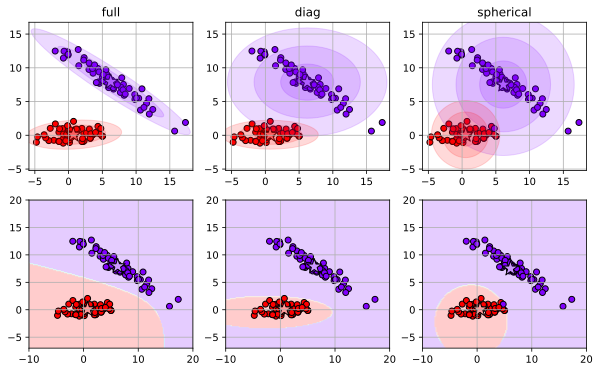

In [35]:
efig

# How to select K?
- Clustering results depends on the number of clusters used.
- We don't typically know this information beforehand.

# Dirichlet Process GMM
  - GMM is extended to automatically select the value of $K$
    - use a "Dirichlet Process" to model $K$ as a random variable.
  - _concentration_ parameter $\alpha$ controls the range of $K$ values that are preferred
    - higher values encourage more clusters
    - lower values encourage less clusters
    - expected number of clusers is $\alpha \log N$, where $N$ is the number of points.
  - (more details in the lecture on graphical models)

In [36]:
# alpha = concentration parameter
# n_components = the max number of components to consider
dpgmm = mixture.BayesianGaussianMixture(covariance_type='full', 
                   weight_concentration_prior=1, 
                   n_components=5, max_iter=100, random_state=4487)
dpgmm.fit(X)
Y = dpgmm.predict(X)
cl = unique(Y)         # find active clusters
newK = len(cl)         # number of clusters
cc = dpgmm.means_[cl]  # get means

In [37]:
dfig = plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.scatter(X[:,0],X[:,1], c='b', edgecolors='k')
plt.axis('equal'); plt.grid(True)

ax = plt.subplot(1,3,2)
Knew = plot_clusters(dpgmm, axbox, X, Y, rbow, rbow2)
plt.axis('equal'); plt.grid(True)
plt.title('DPGMM (' + str(dpgmm.n_components) + " -> " + str(Knew[0]) + " clusters)")

gmm = mixture.GaussianMixture(n_components=5, covariance_type='full', random_state=4487, n_init=10)
gmm.fit(X)
Y2 = gmm.predict(X)

plt.subplot(1,3,3)
plot_clusters(gmm, axbox, X, Y2, rbow, rbow2)
plt.axis('equal'); plt.grid(True)
plt.title('GMM (' + str(gmm.n_components) + " clusters)")
plt.close()

- DPGMM automatically selects 2 components from 5
  - for comparison, GMM with 5 clusters looks messy

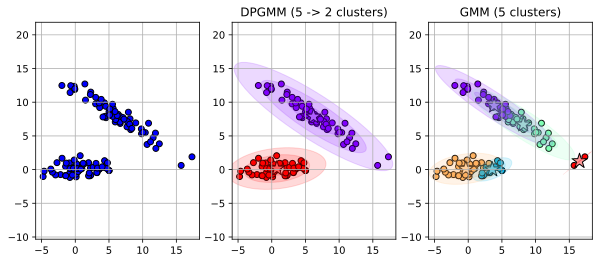

In [38]:
dfig

In [39]:
# make some random data
Xblob = array([])
random.seed(120)
for i in range(5):
    mu = random.uniform(-5,5,(1,2))
    
    st = 0.2*random.normal(0,1,(2,2)) + 0.2*identity(2)
    X1 = dot(random.normal(0,1,[60, 2]), st.T) + mu

    if i==0:
        Xblob = X1
    else:
        Xblob = r_[Xblob,X1]
X = Xblob
axbox = [-6, 6, -7, 2]

- For different concentration parameter $\alpha$
  - larger $\alpha$ may yield more clusters

In [40]:
dpfig = plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.scatter(X[:,0], X[:,1], c='b', edgecolors='k')
plt.axis(axbox); plt.grid(True)

for i,alpha in enumerate(logspace(-5,3,5)):   
    dpgmm = mixture.BayesianGaussianMixture(covariance_type='full', 
                   weight_concentration_prior=alpha, 
                   n_components=10, max_iter=100, random_state=6487)
    dpgmm.fit(X)
    Y = dpgmm.predict(X)

    plt.subplot(2,3,i+2)
    Knew = plot_clusters(dpgmm, axbox, X, Y, rbow, rbow2)
    plt.grid(True)
    plt.title("$\\alpha$="+str(alpha)+"; " + str(Knew[0])+ " clusters")
plt.tight_layout()
plt.close()

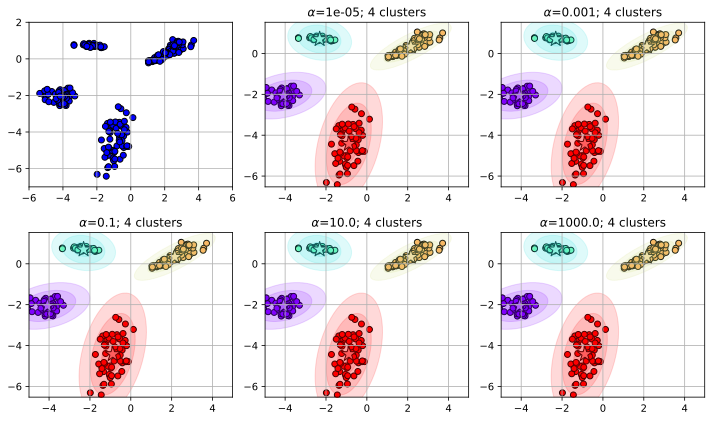

In [41]:
dpfig

- Choice of $\alpha$ is not that critical
  - same number of clusters for large ranges of $\alpha$

In [42]:
alphas = logspace(-10,10,40)
allKs = zeros(alphas.shape)
for i,alpha in enumerate(alphas):
    dpgmm = mixture.BayesianGaussianMixture(covariance_type='full', weight_concentration_prior=alpha, 
                          n_components=10, max_iter=100, 
                            random_state=6487)
    dpgmm.fit(X)
    allKs[i] = len(unique(dpgmm.predict(X)))

dpgmmafig = plt.figure()
plt.semilogx(alphas, allKs, '.-', drawstyle='steps-post')
plt.grid(True)
plt.axis([min(alphas), max(alphas), 0, 5]);
plt.xlabel('$\\alpha$'); plt.ylabel('K')
plt.close()

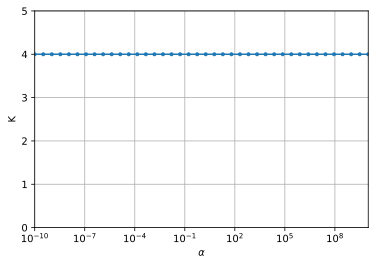

In [43]:
dpgmmafig